https://colab.research.google.com/drive/1Ok2TyWayHXFJedppb39mFvua3q2cU244?usp=sharing

In [ ]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_df = pd.read_csv('/content/drive/MyDrive/content/features.csv')
val_df   = pd.read_csv('/content/drive/MyDrive/content/features_v.csv')

print("Train shape:", train_df.shape)
print("Val   shape:", val_df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shape: (6248, 21)
Val   shape: (299, 21)


In [ ]:
# Cell 3: Select numeric graph features
feature_cols = [
    'num_nodes','num_edges','average_degree','density',
    'average_clustering','assortativity','transitivity',
    'avg_degree_centrality','avg_betweenness_centrality',
    'avg_closeness_centrality','edge_weight_mean',
    'edge_weight_std','label_overlap_with_country'
]
# drop any zero‐variance features
stds = train_df[feature_cols].std(ddof=0)
feature_cols = [f for f in feature_cols if stds[f] != 0]
print("Using features:", feature_cols)

Using features: ['num_nodes', 'num_edges', 'average_degree', 'density', 'average_clustering', 'assortativity', 'transitivity', 'avg_degree_centrality', 'avg_betweenness_centrality', 'avg_closeness_centrality', 'edge_weight_mean', 'edge_weight_std', 'label_overlap_with_country']


In [ ]:
# Cell 4: Encode labels
le = LabelEncoder()
train_df['label_idx'] = le.fit_transform(train_df['label'])
val_df  ['label_idx'] = le.transform( val_df['label'])
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Class mapping: {'cultural agnostic': np.int64(0), 'cultural exclusive': np.int64(1), 'cultural representative': np.int64(2)}


In [ ]:
# Cell 5: Impute + Scale
# 5a) Replace infinite with NaN
train_df[feature_cols] = train_df[feature_cols].replace([np.inf, -np.inf], np.nan)
val_df  [feature_cols] = val_df  [feature_cols].replace([np.inf, -np.inf], np.nan)

# 5b) Impute missing with median
imp = SimpleImputer(strategy='median')
X_train = imp.fit_transform(train_df[feature_cols])
X_val   = imp.transform(   val_df[feature_cols])

# 5c) Standard scaling (zero mean, unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(  X_val)

# ensure correct dtype
X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)

y_train = train_df['label_idx'].values
y_val   = val_df['label_idx'].values

print("Features shape:", X_train.shape, X_val.shape)

Features shape: (6248, 13) (299, 13)


In [ ]:
# Cell 6: PyTorch Dataset + DataLoader
class GraphFeatureDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = GraphFeatureDataset(X_train, y_train)
val_ds   = GraphFeatureDataset(X_val,   y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)

In [ ]:
# Cell 7: Define a 3-layer NN with BatchNorm + Dropout
class ThreeLayerNet(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ThreeLayerNet(len(feature_cols), len(le.classes_)).to(device)
print(model)

ThreeLayerNet(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=3, bias=True)
  )
)


In [ ]:
# Cell 8: Loss, Optimizer, Scheduler & Early Stopping
# class weights inverse to frequency
counts = np.bincount(y_train)
class_weights = torch.tensor(1.0/counts, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

best_val_acc = 0.0
no_improve   = 0
patience     = 10

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Cell 9: Training Loop
num_epochs = 50

for epoch in range(1, num_epochs+1):
    # Training
    model.train()
    train_loss = 0.0; train_corr = train_tot = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()*yb.size(0)
        preds = logits.argmax(dim=1)
        train_corr += (preds==yb).sum().item()
        train_tot  += yb.size(0)

    train_loss /= train_tot
    train_acc   = train_corr / train_tot

    # Validation
    model.eval()
    val_loss = 0.0; val_corr = val_tot = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss   = criterion(logits, yb)
            val_loss += loss.item()*yb.size(0)
            preds = logits.argmax(dim=1)
            val_corr += (preds==yb).sum().item()
            val_tot  += yb.size(0)

    val_loss /= val_tot
    val_acc   = val_corr / val_tot

    scheduler.step(val_acc)
    print(f"Epoch {epoch:02d} | Train loss {train_loss:.6f} acc {train_acc:.4f} | "
          f"Val loss {val_loss:.6f} acc {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        no_improve   = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping.")
            break

print("Best Validation Accuracy:", best_val_acc)

Epoch 01 | Train loss 1.161200 acc 0.3311 | Val loss 1.116479 acc 0.3813
Epoch 02 | Train loss 1.117839 acc 0.3708 | Val loss 1.067257 acc 0.4448
Epoch 03 | Train loss 1.098162 acc 0.3942 | Val loss 1.040832 acc 0.4515
Epoch 04 | Train loss 1.085766 acc 0.4123 | Val loss 1.033291 acc 0.5017
Epoch 05 | Train loss 1.078579 acc 0.4209 | Val loss 1.021202 acc 0.5117
Epoch 06 | Train loss 1.069000 acc 0.4331 | Val loss 1.009177 acc 0.5117
Epoch 07 | Train loss 1.061342 acc 0.4520 | Val loss 1.000522 acc 0.5351
Epoch 08 | Train loss 1.058190 acc 0.4611 | Val loss 0.996939 acc 0.5251
Epoch 09 | Train loss 1.061297 acc 0.4528 | Val loss 0.993366 acc 0.5284
Epoch 10 | Train loss 1.054436 acc 0.4560 | Val loss 0.987877 acc 0.5385
Epoch 11 | Train loss 1.063152 acc 0.4574 | Val loss 0.974911 acc 0.5251
Epoch 12 | Train loss 1.049526 acc 0.4664 | Val loss 0.983636 acc 0.5485
Epoch 13 | Train loss 1.056931 acc 0.4625 | Val loss 0.981516 acc 0.5385
Epoch 14 | Train loss 1.044730 acc 0.4677 | Val los

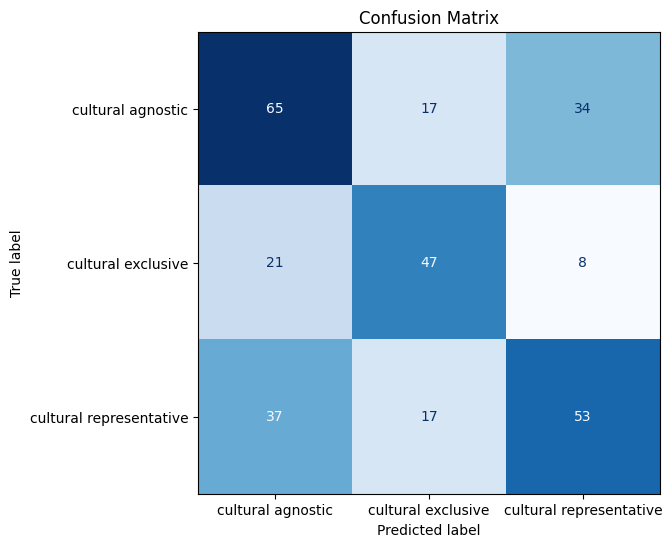


Classification Report:

                         precision    recall  f1-score   support

      cultural agnostic       0.53      0.56      0.54       116
     cultural exclusive       0.58      0.62      0.60        76
cultural representative       0.56      0.50      0.52       107

               accuracy                           0.55       299
              macro avg       0.56      0.56      0.56       299
           weighted avg       0.55      0.55      0.55       299



In [ ]:
# Cell 10: Confusion Matrix + Classification Report
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for Xb, yb in val_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix')
plt.show()

print('\nClassification Report:\n')
print(classification_report(all_labels, all_preds, target_names=le.classes_))